In [179]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

In [61]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [2]:
#nltk.download()

In [2]:
with open('yelp_academic_dataset_review.json', 'rb') as f:
    data = f.readlines()

data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
data_df = pd.read_json(data_json_str)

In [147]:
# extract features and labels from the dataset that are going to be used
filtered_data = data_df[['text', 'stars']][:50000]

In [148]:
# remove non-alphanumeric characters
filtered_data['text'] = filtered_data['text'].map(lambda f: re.sub('\W+', ' ', f))

In [149]:
# stem words to reduce multiple variations of the same word
stemmer = SnowballStemmer('english')
text = filtered_data['text']
text = [' '.join([stemmer.stem(word) for word in review.split(' ')]) for review in text]

In [150]:
# remove words that have little relevance to the meaning of the text
stop_words = set(stopwords.words('english'))
text = [' '.join([word for word in review.split(' ') if not word in stop_words]) for review in text]
filtered_data['text'] = text

In [151]:
# separate into training and test data
training_data, test_data = train_test_split(filtered_data, test_size = 0.3)

In [152]:
# separate into features and labels
features_train = training_data['text']
labels_train = training_data['stars']
features_test = test_data['text']
labels_test = test_data['stars']

In [194]:
# vectorize text based on occurences of each word in the bag of words
vectorizer = CountVectorizer(analyzer='word', max_features=5000, ngram_range=(1, 6))
vectorizer.fit(features_train)
vectorized_features_train = vectorizer.transform(features_train)
vectorized_labels_test = vectorizer.transform(features_test)

In [195]:
# de-emphasize words that occur frequently throughout all the reviews
tfidf = TfidfTransformer()
tfidf = tfidf.fit(vectorized_features_train)
tfidf_features_train = tfidf.transform(vectorized_features_train)
tfidf_features_test = tfidf.transform(vectorized_labels_test)

In [144]:
clf = GaussianNB()
title = "Learning Curves (Naive Bayes)"
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
plot_learning_curve(clf, title, tfidf_features_train.toarray(), labels_train, cv=cv, ylim=(-1, 1), n_jobs=3)

<module 'matplotlib.pyplot' from '/Users/richieshi/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

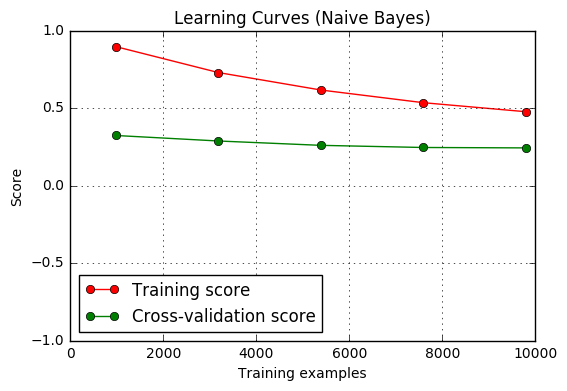

In [145]:
plt.show()

In [128]:
svmClf = SVC(C=5, gamma=0.1)
title = "Learning Curves (SVM)"
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
plot_learning_curve(svmClf, title, tfidf_features_train.toarray(), labels_train, cv=cv, ylim=(-1, 1), n_jobs=3)

<module 'matplotlib.pyplot' from '/Users/richieshi/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

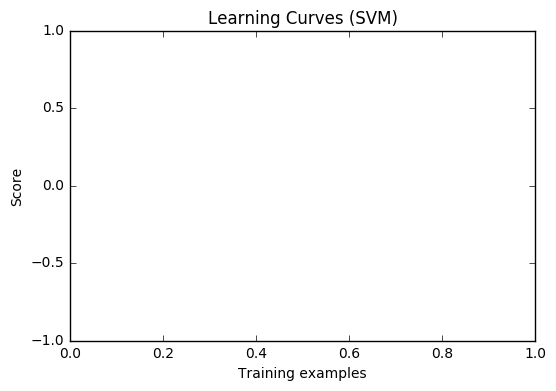

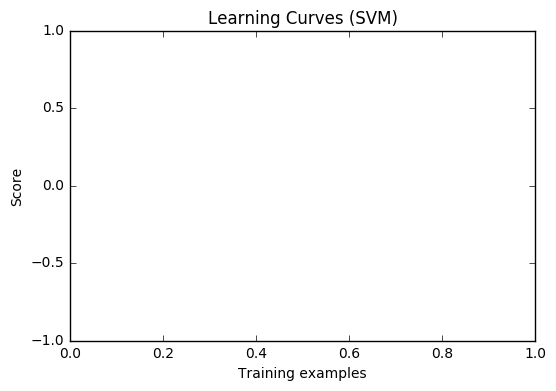

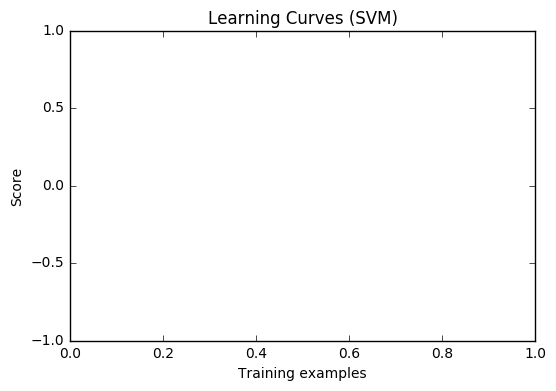

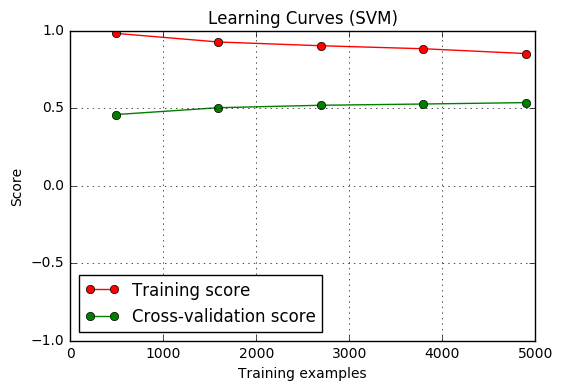

In [129]:
plt.show()

/Users/richieshi/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/richieshi/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/richieshi/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


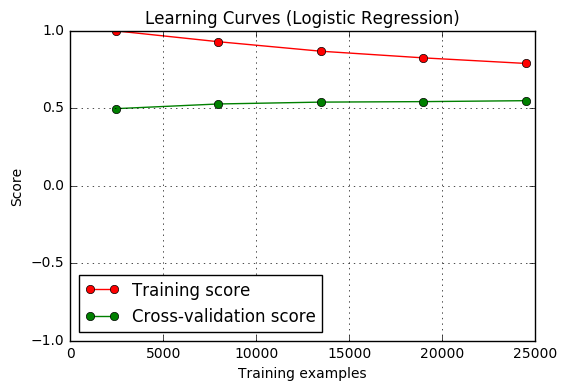

In [196]:
regressionClf = LogisticRegression(C=6.4, multi_class='multinomial', solver='newton-cg')
regressionClf.fit(tfidf_features_train.toarray(), labels_train)
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
plot_learning_curve(regressionClf, title, tfidf_features_train.toarray(), labels_train, cv=cv, ylim=(-1, 1), n_jobs=3)
plt.show()

In [206]:
regressionClf.predict(tfidf.transform(vectorizer.transform([""])))

array([4])

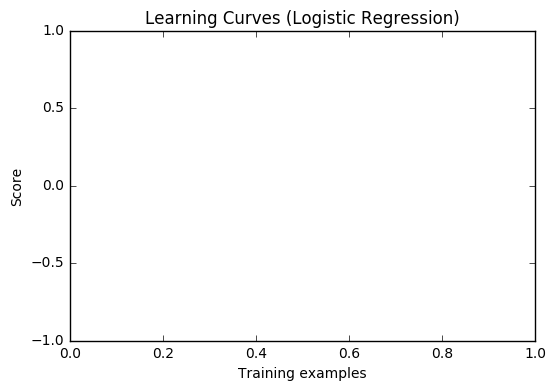

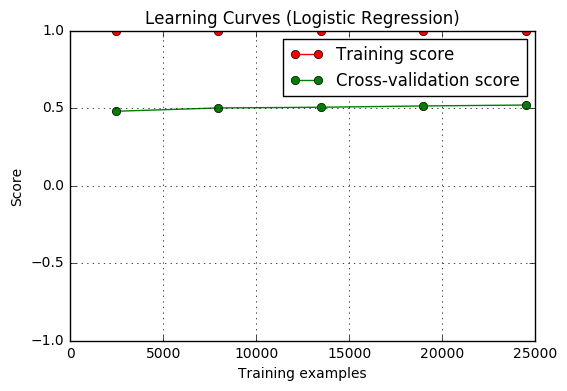

In [180]:
forest = RandomForestClassifier(n_estimators=100)
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
plot_learning_curve(forest, title, tfidf_features_train.toarray(), labels_train, cv=cv, ylim=(-1, 1), n_jobs=3)
plt.show()